In [296]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from xgboost import XGBClassifier
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import the necessary packages

In [297]:
train = pd.read_csv("train.csv")
train.head()

test = pd.read_csv("test.csv")
test.head()

data = pd.concat([train, test]).reset_index(drop=True)
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported  
0       False  
1        True  
2       False  
3       False  
4        True

In [298]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


<Axes: xlabel='VIP', ylabel='count'>

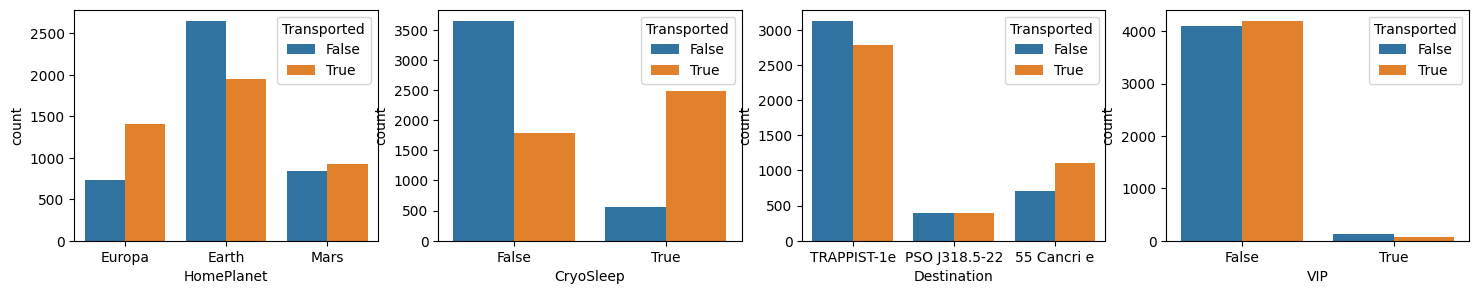

In [299]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3))

sns.countplot(data, x="HomePlanet", hue="Transported", ax=axes[0])
sns.countplot(data, x="CryoSleep", hue="Transported", ax=axes[1])
sns.countplot(data, x="Destination", hue="Transported", ax=axes[2])
sns.countplot(data, x="VIP", hue="Transported", ax=axes[3])

<Axes: xlabel='Transported', ylabel='count'>

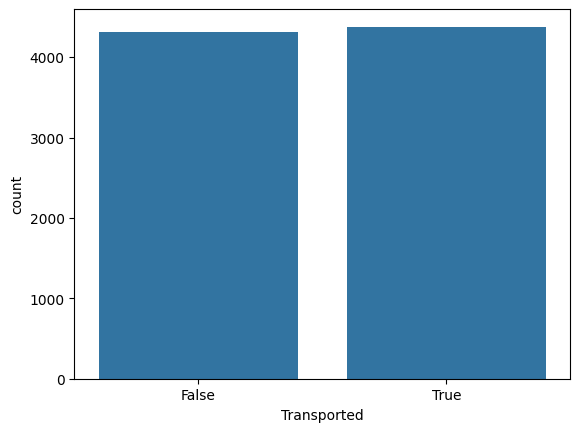

In [300]:
sns.countplot(data, x="Transported")

<Axes: xlabel='Age', ylabel='Percent'>

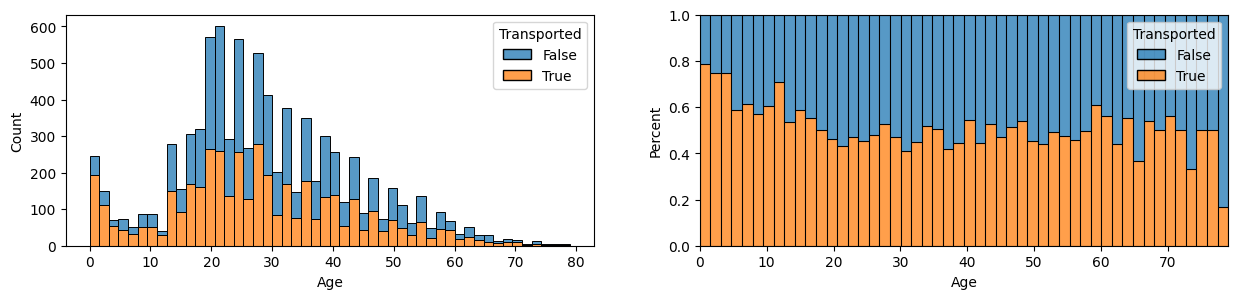

In [301]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

sns.histplot(data=data, x="Age", hue="Transported", bins=50, multiple='stack', ax=axes[0])
sns.histplot(data=data, x="Age", hue="Transported", bins=50, multiple='fill', stat='percent', ax=axes[1])

In [302]:
data[['CabinDeck', 'CabinNum', 'CabinSide']] = data['Cabin'].str.split('/', expand=True)
data['CabinNum'] = data['CabinNum'].fillna(0)
data['CabinNum'] = data['CabinNum'].astype('int')

data = data.drop('Cabin',axis=1)

In [303]:
data[['GroupNumber', 'PassengerNumber']] = data['PassengerId'].str.split('_', expand=True)
data['GroupNumber'] = data['GroupNumber'].astype('int')
data['PassengerNumber'] = data['PassengerNumber'].astype('int')

In [304]:
target = data.pop('Transported')
data['Transported'] = target
# insert Transported at the end of columns for correlation

In [305]:
data_corr = pd.DataFrame(data)
data_corr = data_corr.dropna()

le = LabelEncoder()

for col in data_corr.select_dtypes(include='object').columns:
    data_corr[col] = le.fit_transform(data_corr[col])

<Axes: >

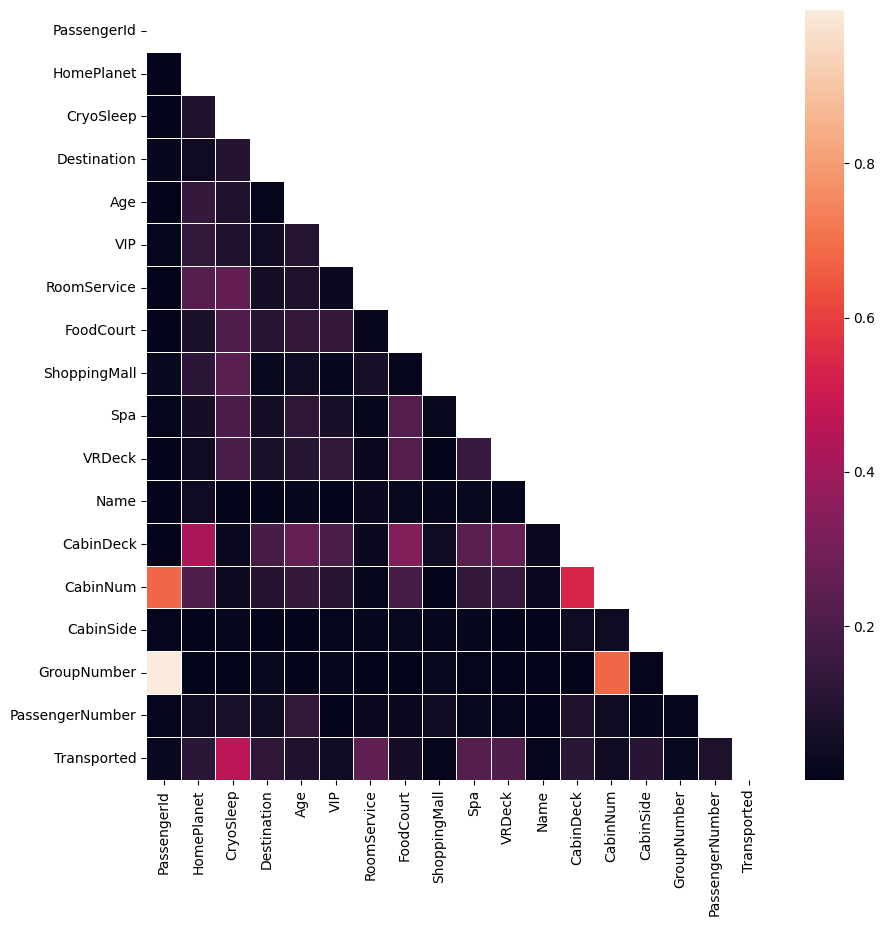

In [306]:
f, ax = plt.subplots(figsize=(10, 10))

corr = data_corr.corr().abs()
matrix_mask = np.triu(np.ones_like(corr)) # only show the upper triangular for the correlation matrix
sns.heatmap(corr, linewidths=.5, mask=matrix_mask)

Filling out missing NAN

In [307]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12682 non-null  object 
 2   CryoSleep        12660 non-null  object 
 3   Destination      12696 non-null  object 
 4   Age              12700 non-null  float64
 5   VIP              12674 non-null  object 
 6   RoomService      12707 non-null  float64
 7   FoodCourt        12681 non-null  float64
 8   ShoppingMall     12664 non-null  float64
 9   Spa              12686 non-null  float64
 10  VRDeck           12702 non-null  float64
 11  Name             12676 non-null  object 
 12  CabinDeck        12671 non-null  object 
 13  CabinNum         12970 non-null  int32  
 14  CabinSide        12671 non-null  object 
 15  GroupNumber      12970 non-null  int32  
 16  PassengerNumber  12970 non-null  int32  
 17  Transported 

In [308]:
data['VIP'] = data['VIP'].transform(lambda x: x.fillna(x.mode()[0]))
data['CryoSleep'] = data['CryoSleep'].transform(lambda x: x.fillna(x.mode()[0]))
data['CabinDeck'] = data['CabinDeck'].transform(lambda x: x.fillna('U')) # unknown nans
data['CabinSide'] = data.groupby(by=["CryoSleep"])['CabinSide'].transform(lambda x: x.fillna(x.mode()[0]))
data['Destination'] = data.groupby(by=["CabinDeck"])['Destination'].transform(lambda x: x.fillna(x.mode()[0]))
data['HomePlanet'] = data.groupby(by=["CabinDeck"])['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0]))
data['Age'] = data.groupby(by=["CabinDeck"])['Age'].transform(lambda x: x.fillna(x.mean()))

data['RoomService'] = data['RoomService'].fillna(0.0)
data['FoodCourt'] = data['FoodCourt'].fillna(0.0)
data['ShoppingMall'] = data['ShoppingMall'].fillna(0.0)
data['Spa'] = data['Spa'].fillna(0.0)
data['VRDeck'] = data['VRDeck'].fillna(0.0)

In [309]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12970 non-null  object 
 2   CryoSleep        12970 non-null  bool   
 3   Destination      12970 non-null  object 
 4   Age              12970 non-null  float64
 5   VIP              12970 non-null  bool   
 6   RoomService      12970 non-null  float64
 7   FoodCourt        12970 non-null  float64
 8   ShoppingMall     12970 non-null  float64
 9   Spa              12970 non-null  float64
 10  VRDeck           12970 non-null  float64
 11  Name             12676 non-null  object 
 12  CabinDeck        12970 non-null  object 
 13  CabinNum         12970 non-null  int32  
 14  CabinSide        12970 non-null  object 
 15  GroupNumber      12970 non-null  int32  
 16  PassengerNumber  12970 non-null  int32  
 17  Transported 

<Axes: xlabel='CabinSide', ylabel='count'>

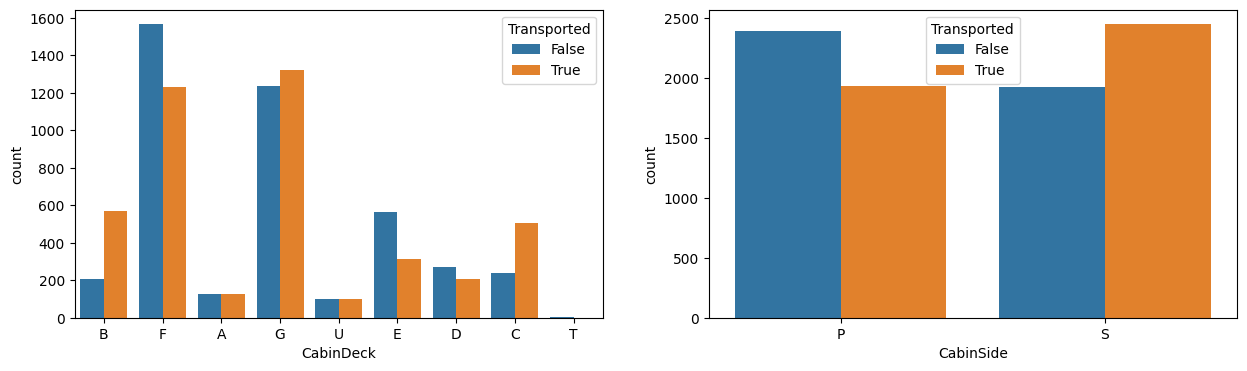

In [310]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.countplot(data,x="CabinDeck",hue="Transported",ax=axes[0])
sns.countplot(data,x="CabinSide",hue="Transported",ax=axes[1])

In [311]:
data['CabinDeck'] = data['CabinDeck'].replace({'C': 'B', 'T': 'E', 'F': 'E'})

In [312]:
value_counts = data['GroupNumber'].value_counts().to_dict()
data['GroupCount'] = data['GroupNumber'].map(value_counts)

In [313]:
data[['First_Name', 'Last_Name']] = data['Name'].str.split(' ', expand=True)

le = LabelEncoder()
data['Last_Name_ID'] = le.fit_transform(data['Last_Name'])

value_counts = data['Last_Name_ID'].value_counts().to_dict()
data['FamilyCount'] = data['Last_Name_ID'].map(value_counts)

data = data.drop(['Name','First_Name','Last_Name', 'Last_Name_ID'],axis=1)
data.head()

PassengerId HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa      False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth      False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa      False  TRAPPIST-1e  58.0   True         43.0   
3     0003_02     Europa      False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth      False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck CabinDeck  CabinNum CabinSide  \
0        0.0           0.0     0.0     0.0         B         0         P   
1        9.0          25.0   549.0    44.0         E         0         S   
2     3576.0           0.0  6715.0    49.0         A         0         S   
3     1283.0         371.0  3329.0   193.0         A         0         S   
4       70.0         151.0   565.0     2.0         E         1         S   

   GroupNumber  PassengerNumber Transported  GroupCount  FamilyCount  
0            1                1       False           1            3  
1            2                1        True           1            4  
2            3                1       False           2            7  
3            3                2       False           2            7  
4            4                1        True           1            9

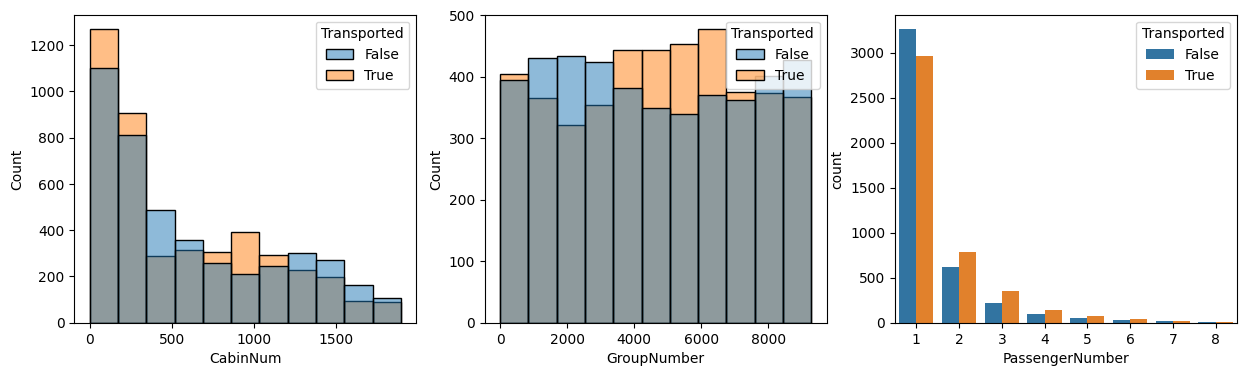

In [314]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(data=data, x="CabinNum", hue="Transported",bins=11,ax=axes[0])
sns.histplot(data=data, x="GroupNumber", hue="Transported",bins=11,ax=axes[1])
sns.countplot(data=data, x="PassengerNumber", hue="Transported",ax=axes[2])

data['PassengerNumber'] = data['PassengerNumber'].replace({3: 2})
data['PassengerNumber'] = data['PassengerNumber'].replace({8: 7})
data['PassengerNumber'] = data['PassengerNumber'].replace({7: 4, 6: 4, 5: 4})

<Axes: xlabel='PassengerNumber', ylabel='count'>

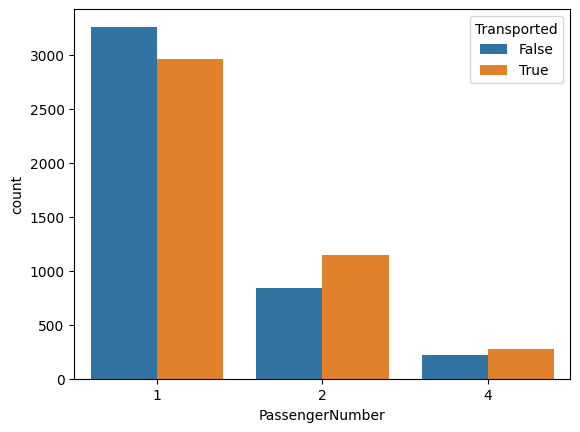

In [315]:
sns.countplot(data=data, x="PassengerNumber", hue="Transported")

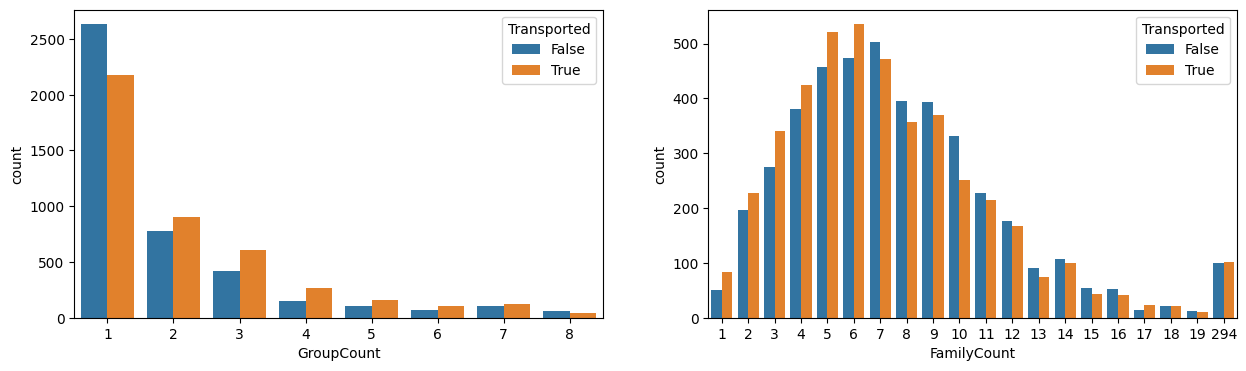

In [316]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.countplot(data=data, x="GroupCount", hue="Transported",ax=axes[0])
sns.countplot(data=data, x="FamilyCount", hue="Transported",ax=axes[1])

data['GroupCount'] = data['GroupCount'].replace({8: 6, 7: 6})
data['GroupCount'] = data['GroupCount'].replace({5: 4})

data['FamilySolo'] = (data['FamilyCount'] == 1)
data['FamilyLow'] = (data['FamilyCount'] > 1) & (data['FamilyCount'] < 7)
data['FamilyMed'] = (data['FamilyCount'] > 6) & (data['FamilyCount'] < 11)
data['FamilyHigh'] = (data['FamilyCount'] > 10) & (data['FamilyCount'] < 16)
data['FamilyPacked'] = (data['FamilyCount'] > 15) & (data['FamilyCount'] < 290)
data['FamilyOutlier'] = (data['FamilyCount'] > 290)

<Axes: xlabel='GroupCount', ylabel='count'>

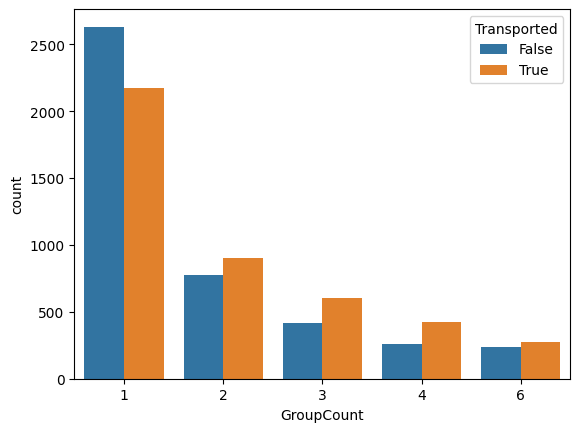

In [317]:
sns.countplot(data=data, x="GroupCount", hue="Transported")

In [318]:
data['TotalAmenities'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']

<Axes: xlabel='TotalAmenities', ylabel='Count'>

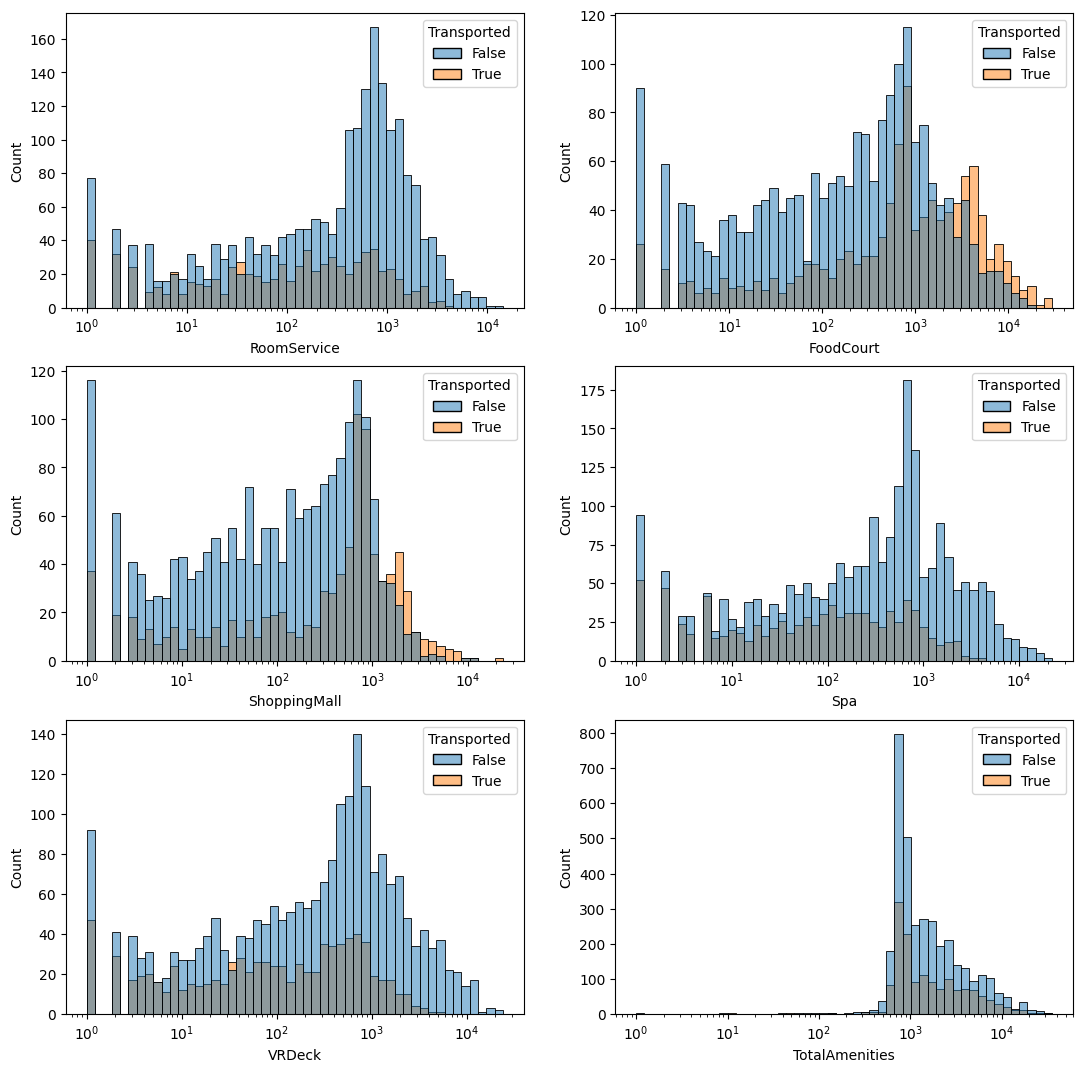

In [319]:
fig, axes = plt.subplots(3, 2, figsize=(13, 13))

sns.histplot(data=data, x="RoomService", hue="Transported",bins=50,log_scale=True,ax=axes[0][0])
sns.histplot(data=data, x="FoodCourt", hue="Transported",bins=50,log_scale=True,ax=axes[0][1])
sns.histplot(data=data, x="ShoppingMall", hue="Transported",bins=50,log_scale=True,ax=axes[1][0])
sns.histplot(data=data, x="Spa", hue="Transported",bins=50,log_scale=True,ax=axes[1][1])
sns.histplot(data=data, x="VRDeck", hue="Transported",bins=50,log_scale=True,ax=axes[2][0])
sns.histplot(data=data, x="TotalAmenities", hue="Transported",bins=50,log_scale=True,ax=axes[2][1])

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12970 non-null  object 
 2   CryoSleep        12970 non-null  bool   
 3   Destination      12970 non-null  object 
 4   Age              12970 non-null  float64
 5   VIP              12970 non-null  bool   
 6   RoomService      12970 non-null  float64
 7   FoodCourt        12970 non-null  float64
 8   ShoppingMall     12970 non-null  float64
 9   Spa              12970 non-null  float64
 10  VRDeck           12970 non-null  float64
 11  CabinDeck        12970 non-null  object 
 12  CabinNum         12970 non-null  int32  
 13  CabinSide        12970 non-null  object 
 14  GroupNumber      12970 non-null  int32  
 15  PassengerNumber  12970 non-null  int32  
 16  Transported      8693 non-null   object 
 17  GroupCount  

In [321]:
data['RoomService'] = np.log1p(data['RoomService'])
data['FoodCourt'] = np.log1p(data['FoodCourt'])
data['ShoppingMall'] = np.log1p(data['ShoppingMall'])
data['Spa'] = np.log1p(data['Spa'])
data['VRDeck'] = np.log1p(data['VRDeck'])
data['TotalAmenities'] = np.log1p(data['TotalAmenities'])

In [322]:
target = data.pop('Transported')
data['Transported'] = target
# insert Transported at the end of columns for correlation

In [323]:
data_corr = pd.DataFrame(data)
le = LabelEncoder()

for col in data_corr.select_dtypes(include='object').columns:
    data_corr[col] = le.fit_transform(data_corr[col])

<Axes: >

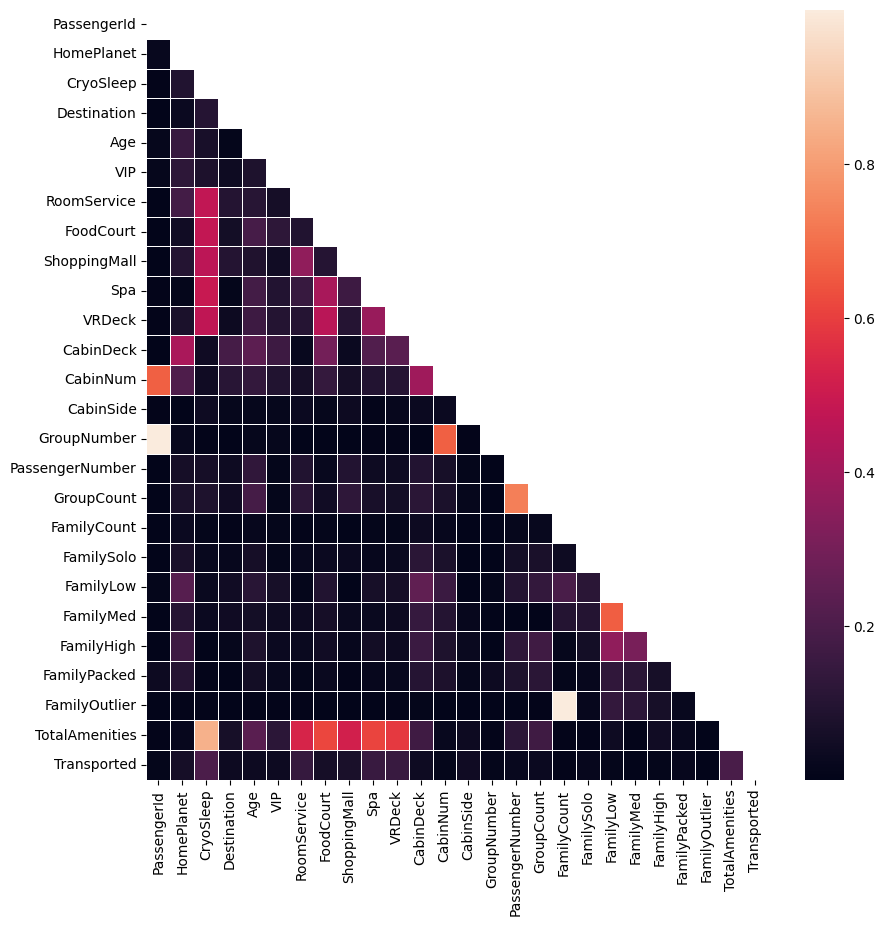

In [324]:
f, ax = plt.subplots(figsize=(10, 10))

corr = data_corr.corr().abs()
matrix_mask = np.triu(np.ones_like(corr)) # only show the upper triangular for the correlation matrix
sns.heatmap(corr, linewidths=.5, mask=matrix_mask)

In [325]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      12970 non-null  object 
 1   HomePlanet       12970 non-null  object 
 2   CryoSleep        12970 non-null  bool   
 3   Destination      12970 non-null  object 
 4   Age              12970 non-null  float64
 5   VIP              12970 non-null  bool   
 6   RoomService      12970 non-null  float64
 7   FoodCourt        12970 non-null  float64
 8   ShoppingMall     12970 non-null  float64
 9   Spa              12970 non-null  float64
 10  VRDeck           12970 non-null  float64
 11  CabinDeck        12970 non-null  object 
 12  CabinNum         12970 non-null  int32  
 13  CabinSide        12970 non-null  object 
 14  GroupNumber      12970 non-null  int32  
 15  PassengerNumber  12970 non-null  int32  
 16  GroupCount       12970 non-null  int64  
 17  FamilyCount 

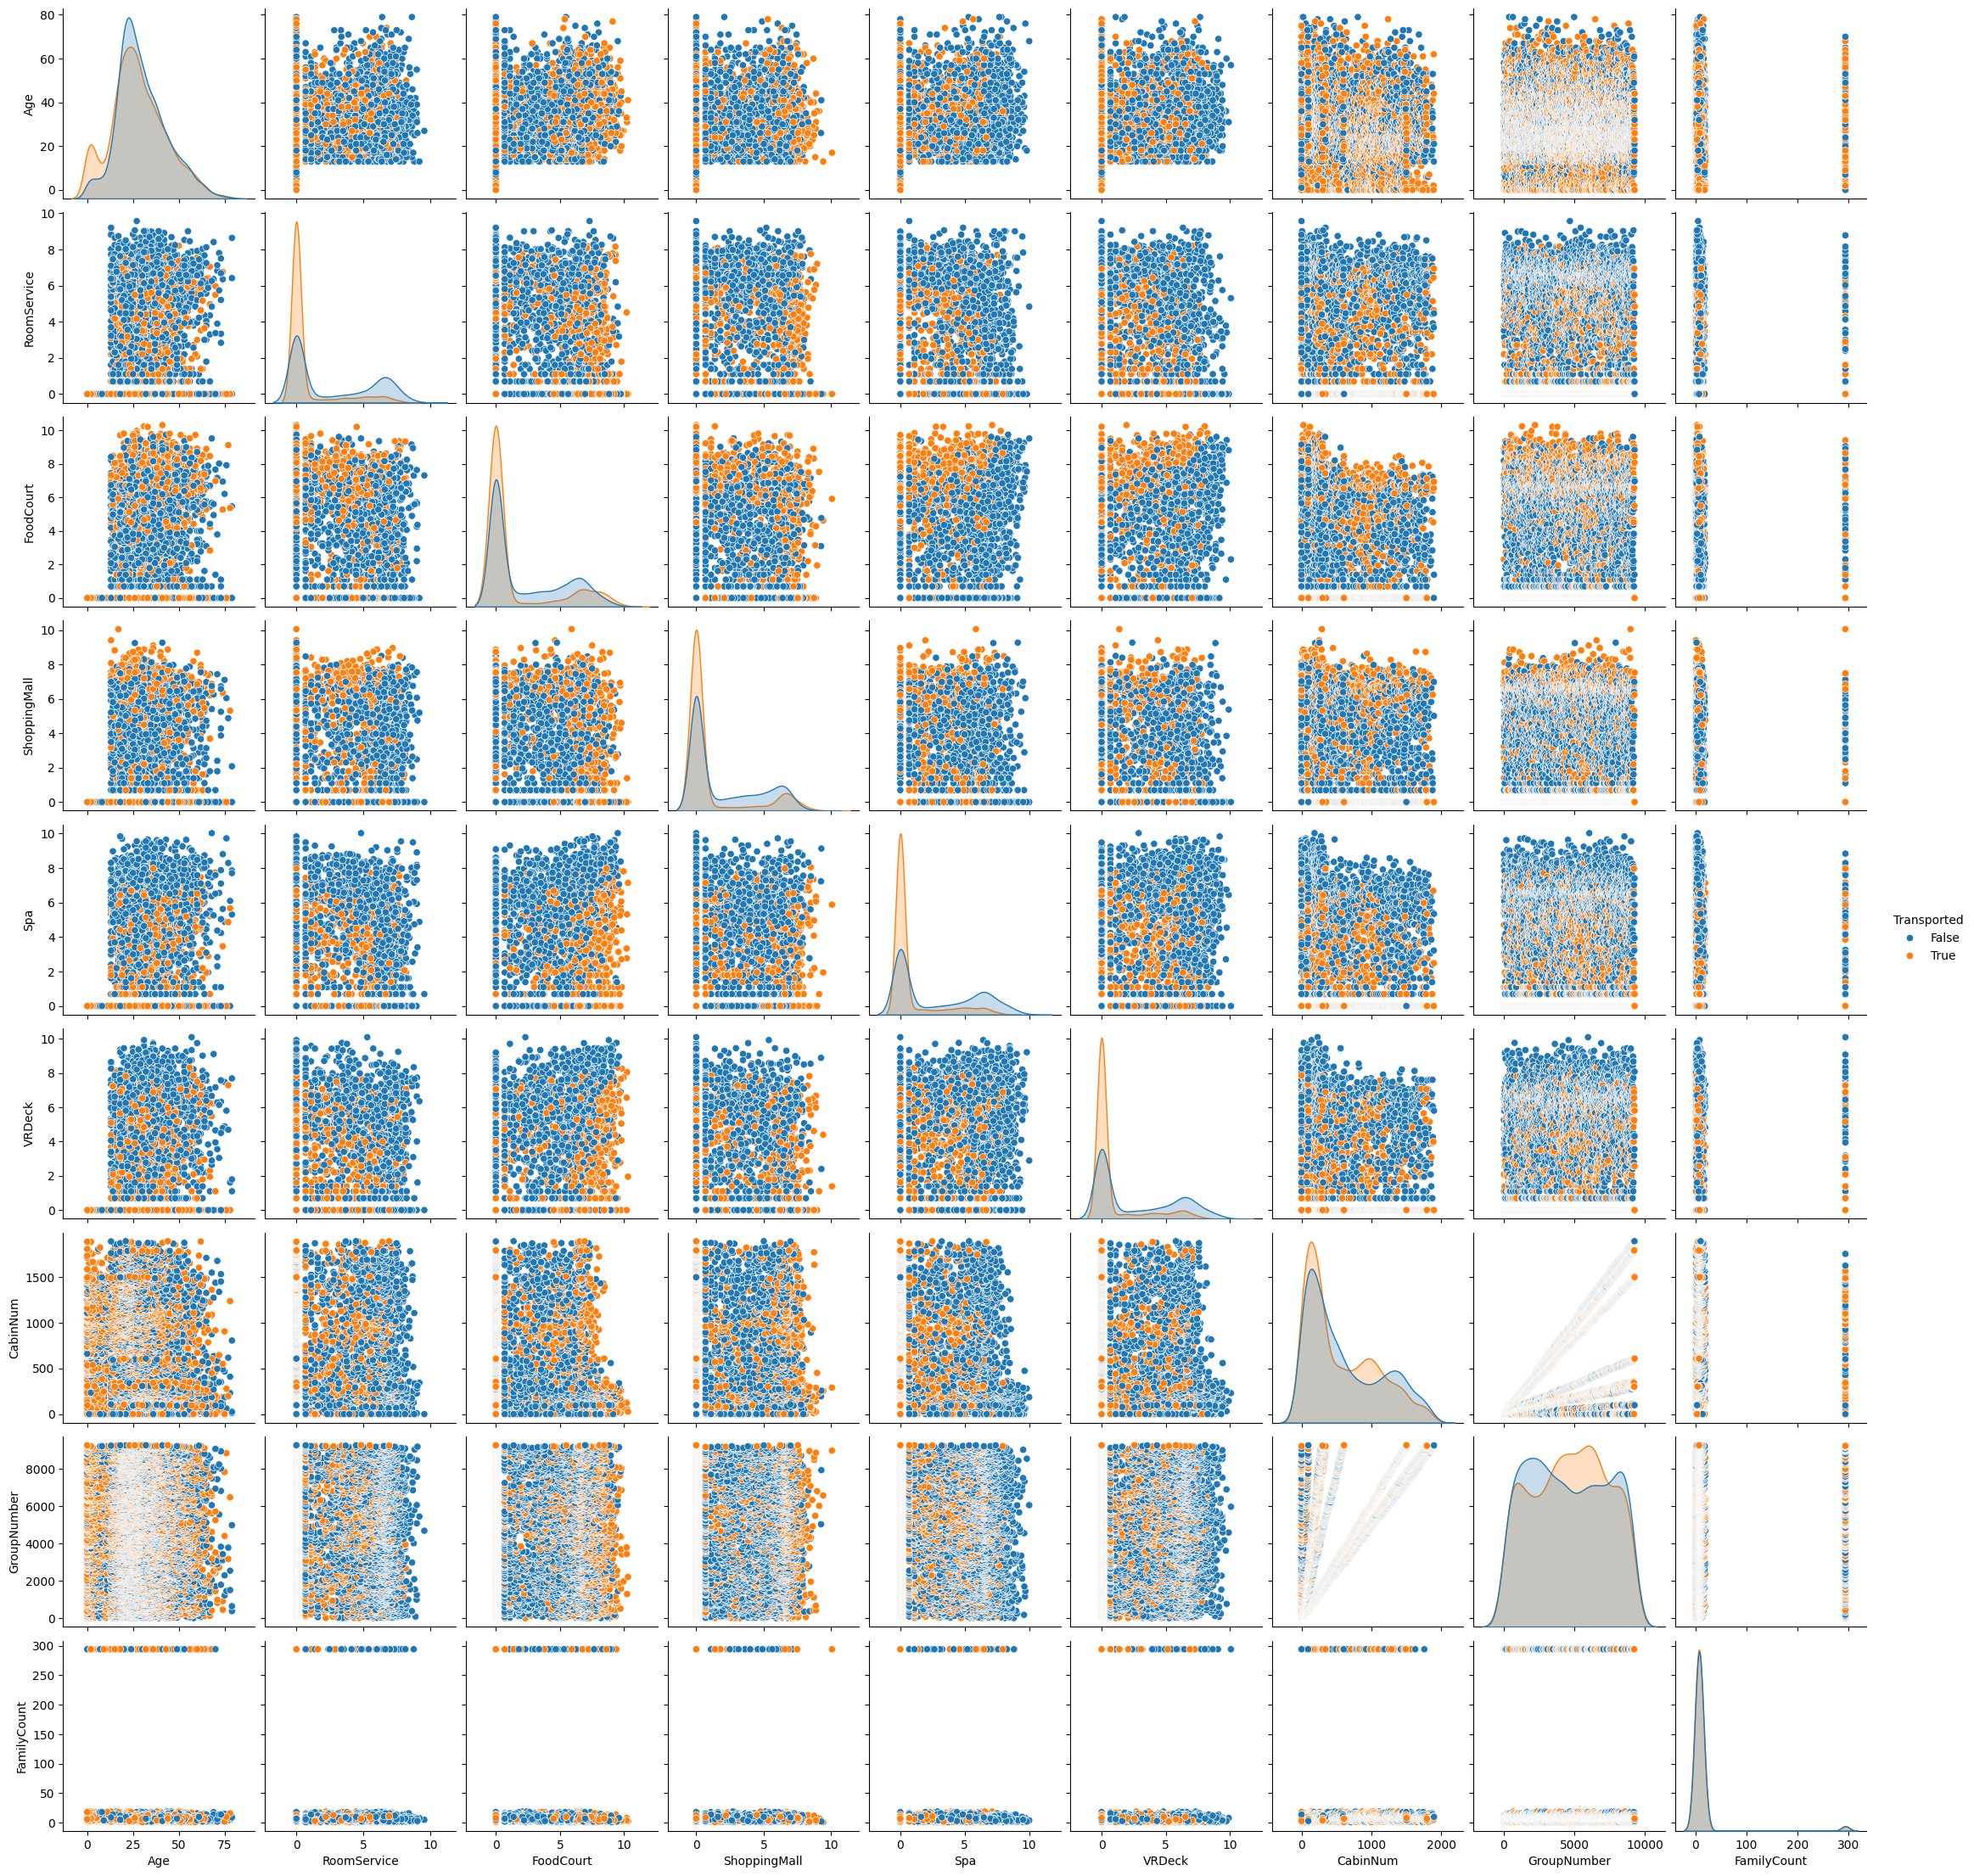

In [326]:
sns.pairplot(data, hue="Transported", vars=["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "CabinNum", "GroupNumber", "FamilyCount"])

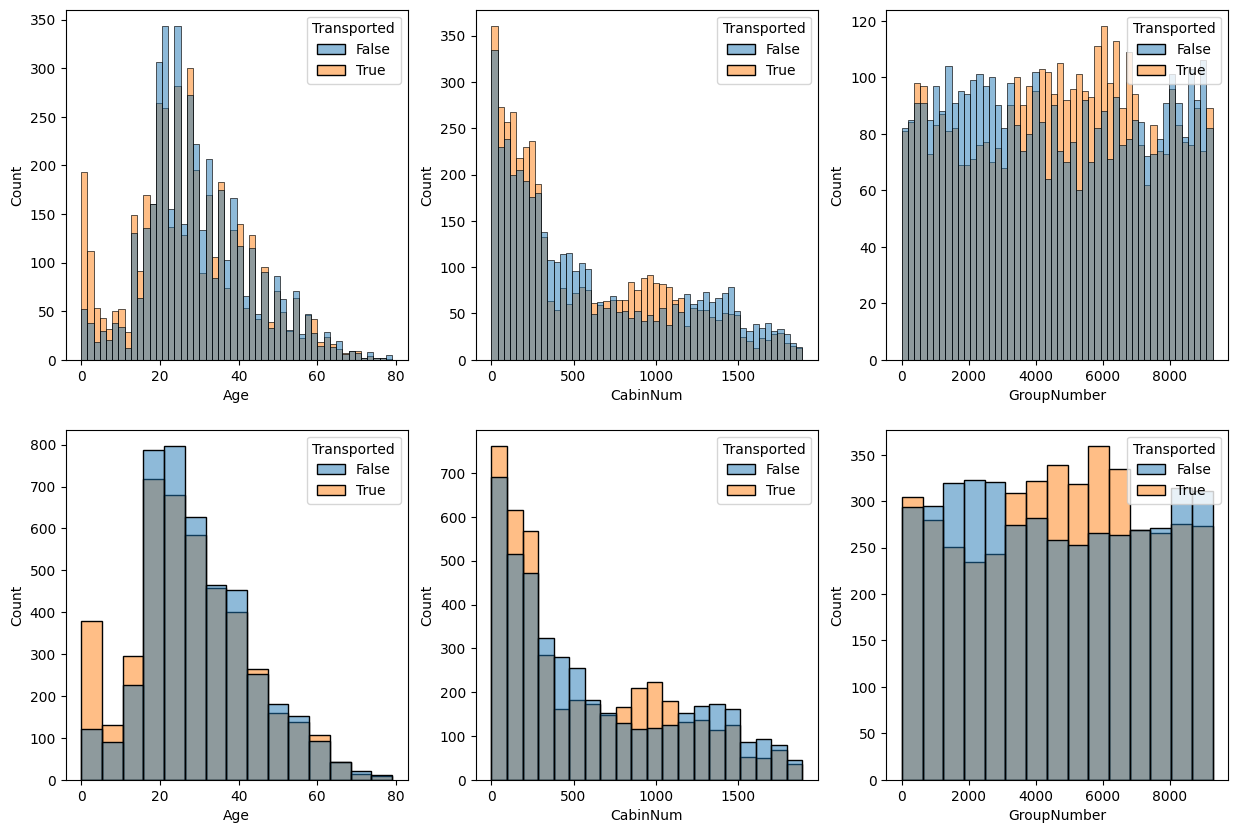

In [327]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(data, x="Age", hue="Transported",bins=50,ax=axes[0][0])
sns.histplot(data, x="CabinNum", hue="Transported",bins=50,ax=axes[0][1])
sns.histplot(data, x="GroupNumber", hue="Transported",bins=50,ax=axes[0][2])

sns.histplot(data, x="Age", hue="Transported",bins=15,ax=axes[1][0])
sns.histplot(data, x="CabinNum", hue="Transported",bins=20,ax=axes[1][1])
sns.histplot(data, x="GroupNumber", hue="Transported",bins=15,ax=axes[1][2])

data['Age'] = pd.cut(data['Age'], bins=15)
data['CabinNum'] = pd.cut(data['CabinNum'], bins=20)
data['GroupNumber'] = pd.cut(data['GroupNumber'], bins=15)

le = LabelEncoder()

for col in ['Age','CabinNum','GroupNumber']:
    data[col] = le.fit_transform(data[col])

data = data.drop('FamilyCount',axis=1)

In [328]:
data = pd.get_dummies(data, columns=['Age', 'CabinNum', 'CabinSide', 'GroupNumber', 'HomePlanet', 'Destination', 'CabinDeck', 'PassengerNumber', 'GroupCount'])
data.head()

PassengerId  CryoSleep    VIP  RoomService  FoodCourt  ShoppingMall  \
0     0001_01      False  False     0.000000   0.000000      0.000000   
1     0002_01      False  False     4.700480   2.302585      3.258097   
2     0003_01      False   True     3.784190   8.182280      0.000000   
3     0003_02      False  False     0.000000   7.157735      5.918894   
4     0004_01      False  False     5.717028   4.262680      5.023881   

        Spa    VRDeck  FamilySolo  FamilyLow  ...  CabinDeck_G  CabinDeck_U  \
0  0.000000  0.000000       False       True  ...        False        False   
1  6.309918  3.806662       False       True  ...        False        False   
2  8.812248  3.912023       False      False  ...        False        False   
3  8.110728  5.267858       False      False  ...        False        False   
4  6.338594  1.098612       False      False  ...        False        False   

   PassengerNumber_1  PassengerNumber_2  PassengerNumber_4 GroupCount_1  \
0               True              False              False         True   
1               True              False              False         True   
2               True              False              False        False   
3              False               True              False        False   
4               True              False              False         True   

   GroupCount_2  GroupCount_3  GroupCount_4  GroupCount_6  
0         False         False         False         False  
1         False         False         False         False  
2          True         False         False         False  
3          True         False         False         False  
4         False         False         False         False  

[5 rows x 88 columns]

In [329]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 88 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12970 non-null  object 
 1   CryoSleep                  12970 non-null  bool   
 2   VIP                        12970 non-null  bool   
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   FamilySolo                 12970 non-null  bool   
 9   FamilyLow                  12970 non-null  bool   
 10  FamilyMed                  12970 non-null  bool   
 11  FamilyHigh                 12970 non-null  bool   
 12  FamilyPacked               12970 non-null  bool   
 13  FamilyOutlier              12970 non-null  boo

In [330]:
train_data = data[data['Transported'].notna()]
test_data = data[data['Transported'].isna()]
test_data = test_data.drop('Transported', axis=1)

test_id = test_data[['PassengerId']].copy()
train_data = train_data.drop('PassengerId', axis=1)
test_data = test_data.drop('PassengerId', axis=1)

In [331]:
X = train_data.drop('Transported', axis=1)
y = (train_data['Transported'] == True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [332]:
xgb_model = XGBClassifier(n_estimators=6000, max_depth=10, learning_rate=0.01)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
xgb_model.fit(X_train, y_train)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.7978144184867778


In [333]:
logistic_model = LogisticRegression(max_iter=500)
scores = cross_val_score(logistic_model, X_train, y_train, cv=5)
logistic_model.fit(X_train, y_train)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.7796936110349678


In [334]:
svm_model = SVC()
scores = cross_val_score(svm_model, X_train, y_train, cv=5)
svm_model.fit(X_train, y_train)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.7962322018732965


In [335]:
rf_model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf_model, X_train, y_train, cv=5)
rf_model.fit(X_train, y_train)
print("Mean CV accuracy:", scores.mean())

Mean CV accuracy: 0.8039984690895737


In [336]:
y_pred_submission = rf_model.predict(test_data)
test_submission = test_id
test_submission['Transported'] = y_pred_submission
test_submission.head()

test_submission.to_csv("submission.csv", index=False)